2022 Nor-s

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
TRAIN_DATA_DIR = '../data/for_generator/train'
VALIDATION_DATA_DIR = '../data/for_generator/val'
TEST_DATA_DIR = '../data/for_generator/test'
 
TRAIN_SAMPLES = 24000
VALIDATION_SAMPLES = 3000
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 112, 112
BATCH_SIZE = 64

In [11]:
def my_preprocess_input(image):
    image = np.array(image)
    converted_img = image/255
    return converted_img

In [12]:
train_datagen = ImageDataGenerator(
                                    preprocessing_function= my_preprocess_input,
                                #    rotation_range=20,
                                #    width_shift_range=0.2,
                                #    height_shift_range=0.2,
                                   zoom_range=0.2)
 
val_datagen = ImageDataGenerator(
    preprocessing_function= my_preprocess_input)

In [13]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    color_mode='grayscale',
                                                    class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False,
    class_mode='categorical')

Found 24000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [14]:
initializer =  'glorot_uniform' # tf.keras.initializers.HeNormal()


filter_num = 32
padding = 'valid'
bias = False
kernel_size = (3, 3)
model2 = models.Sequential([
  # input Nx17x4x3
  tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1]),

  tf.keras.layers.Conv2D(filters = filter_num, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),

  tf.keras.layers.Conv2D(filters = filter_num*2, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Conv2D(filters = filter_num*2, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters = filter_num*4, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.GlobalAveragePooling2D(),
 
  tf.keras.layers.Dense(filter_num, kernel_initializer=initializer, activation = 'relu'),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2,kernel_initializer=initializer, activation = 'softmax'),
])
model2.summary()
# model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) adadelta
# optim =  tf.keras.optimizers.Nadam()
model2.compile( optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])

# model2.compile(optimizer= tf.keras.optimizers.Nadam(learning_rate=learning_rate),loss='mse', metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      288       
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 112, 112, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18432     
                                                                 
 batch_normalization_3 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 112, 112, 64)     

In [15]:
checkpoint_path = "./training_new_mp2/cp-{epoch:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                #  period=5,
                                                 monitor='val_accuracy',
                                                mode='max',
                                                 save_best_only=True)

In [16]:
from distributed import Worker


history = model2.fit(
                train_generator,
                steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
                epochs=30,
                validation_data=validation_generator,
                validation_steps=VALIDATION_SAMPLES // BATCH_SIZE,
                callbacks=[cp_callback ],
                workers = 4
                )

Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.6974
Epoch 1: val_accuracy improved from -inf to 0.50951, saving model to ./training_new_mp2\cp-0001.ckpt
375/375 [==============================] - 48s 120ms/step - loss: 0.5741 - accuracy: 0.6974 - val_loss: 0.9074 - val_accuracy: 0.5095
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7279
Epoch 2: val_accuracy improved from 0.50951 to 0.66270, saving model to ./training_new_mp2\cp-0002.ckpt
375/375 [==============================] - 45s 120ms/step - loss: 0.5338 - accuracy: 0.7279 - val_loss: 0.6848 - val_accuracy: 0.6627
Epoch 3/30
375/375 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7510
Epoch 3: val_accuracy did not improve from 0.66270
375/375 [==============================] - 45s 121ms/step - loss: 0.5065 - accuracy: 0.7510 - val_loss: 1.3798 - val_accuracy: 0.5051
Epoch 4/30
375/375 [==============================] - 

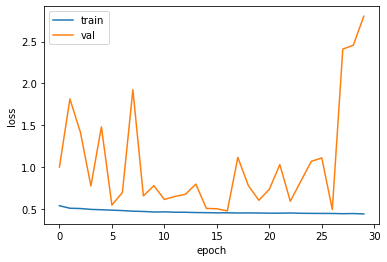

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

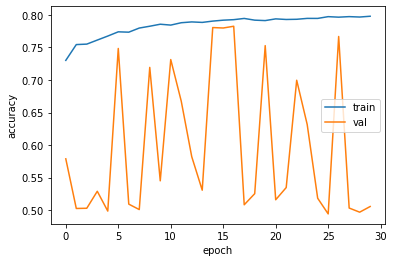

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()